In [6]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [7]:
import os
import cv2 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from keras.datasets import mnist, fashion_mnist, cifar10, cifar100
from keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Dense,
    Input,
    MaxPooling2D,
    UpSampling2D,
)
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from itertools import chain

from sklearn.metrics import confusion_matrix

In [8]:
np.random.seed(42)

In [168]:
ANOMALY_STR ="anomaly"
NORMAL_STR = "normal"
USE_CASE ="bottle"
img_path = os.path.join("imgs",USE_CASE)
if not os.path.isdir(img_path):
    os.mkdir(img_path)
ckpt_path = os.path.join("ckpts",USE_CASE)
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)
data_path = os.path.join("data","mvtec_anomaly_detection")
log_dir= os.path.join("logs",USE_CASE)

if not os.path.isdir(log_dir):
    os.mkdir(log_dir)

classes = list(filter(lambda d:os.path.isdir(os.path.join(data_path,d)),  os.listdir(data_path)))

# Preparing the data

In [10]:
object_categories = ["bottle","cable","capsule","metal_nut","pill","screw","tile","toothbrush","transistor","zipper"]

In [11]:
def read_image_file_names(dir_path):
    """Reads images per category for given directory path.
    Returns images as a generator object in intervall[0,1] rgb-format"""
    # data = np.empty(shape=(0,1,1,3),dtype=np.int8)
    cur_shape= None
    path_to_dir = os.path.join(os.getcwd(),dir_path)
    return [os.path.join(path_to_dir,p) for p in os.listdir(dir_path)]

In [12]:
def load_data():
    normal_path = os.path.join(data_path, USE_CASE, "train", "good")
    normal_train_data = read_image_file_names(normal_path)
    
    test_path = os.path.join(data_path,USE_CASE,"test")
    normal_test_data = read_image_file_names(os.path.join(test_path,"good"))
    anomaly_test_data = []
    for p in os.listdir(test_path):
        if p != "good":#    
            gen = read_image_file_names(os.path.join(test_path,p))
            anomaly_test_data +=  read_image_file_names(os.path.join(test_path,p))
    return normal_train_data, normal_test_data,normal_test_data, anomaly_test_data

In [13]:
X_normal_train, X_normal_validate, X_normal_test, X_anomaly_test = load_data()

In [14]:
def plot_mvtec(data):
    plt.imshow(data)

In [15]:
def hide_axis(subplt, x=True, y=True):
    if x:
        subplt.get_xaxis().set_visible(False)
    if y:
        subplt.get_yaxis().set_visible(False)

In [27]:
def yield_images(file_paths, batch_size,single_batch=False, input_only=False):
    # yields batch_size'd arrays of images, either indefinetly or only one batch for prediction case 
        while True:
            rands = np.random.randint(0,len(file_paths),batch_size)
            #print(rands)
            imgs = np.zeros((batch_size,900,900,3))
            for j,r in enumerate(rands):
                # print(r,len(file_paths))
                fp = file_paths[r]
                if os.path.isfile(fp):
                    img = cv2.imread(fp)   # reads an image in the BGR format
                    imgs[j] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # BGR -> RGB
            
                    
            if not input_only:
                yield imgs / 255, imgs/255
            else: 
                yield imgs /255
            if single_batch:
                break

In [28]:
def plot_samples(row_one, row_two, f_plot, outfile=""):
    """Plot 8 sample images of the row_one and row_two"""
    plt.figure(figsize=(16, 4))
    # row_one
    n = min([8])
    for i in range(n):
        try:
            ax = plt.subplot(2, n, i+1)
            hide_axis(ax)
            f_plot(row_one[i]) # row_one
            ax = plt.subplot(2, n, n+i+1)
        except IndexError:
            pass
        try:
            f_plot(row_two[i]) # row_two
            hide_axis(ax)
        except IndexError:
            pass
    if outfile!="":
        plt.savefig(outfile)

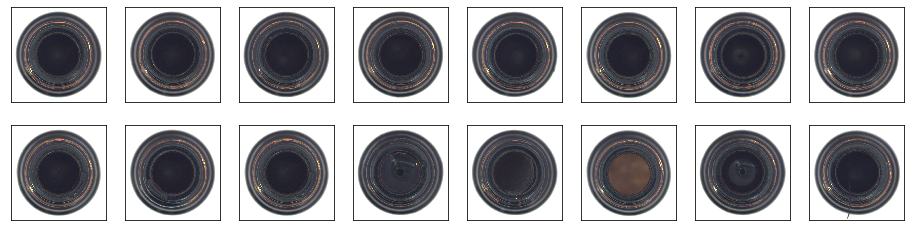

In [29]:
path = os.path.join(img_path, "{}-{}.png".format(NORMAL_STR, ANOMALY_STR))
plot_samples(
    next(yield_images(X_normal_train, 8, single_batch=True, input_only=True)),
    next(yield_images(X_anomaly_test, 8, single_batch=True, input_only=True)),
    plot_mvtec,
    path,
)

# Extracting features with an auto encoder (ae)

In [169]:
def get_codec_from_ae(autoencoder):
    encoder_layer = autoencoder.get_layer("encoder")
    # this model maps an input to its encoded representation; Big image to small rep
    encoder = Model(
        inputs=autoencoder.input, outputs=encoder_layer.output)

    # create a placeholder for an encoded (ENCODING_DIM-dimensional) input
    encoded_input = Input(shape=encoder_layer.output_shape[1:])

    # getting the middle of the autoencoder
    start = (len(autoencoder.layers))//2
    decoder = autoencoder.layers[-start](encoded_input)
    # stacking the decoder layers
    for i in range(start-1, 0, -1):
        decoder = autoencoder.layers[-i](decoder)

    # create the decoder model; "<": encoded(small) representation to big image
    decoder = Model(encoded_input, decoder)
    return encoder, decoder

In [170]:
def build_conv_ae(
    filters, input_shape=(28, 28, 1), kernel=(3, 3), pool_size=(2, 2), color="gray"
):
    # STRETCH GOAL: variable number of layers and pool_size
    pool_size = (2, 2)
    kernel = (3, 3)
    if len(filters) != 4:
        raise ValueError("Four Filters must be given. Sorry.")
    # this is our input placeholder
    input_img = Input(shape=input_shape)
    # layer between input and middle layer
    i = 0
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(input_img)
    encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)
    encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)
    encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)

    # "encoded" is the encoded representation of the input, middle layer of the aue
    encoded = MaxPooling2D(pool_size, padding="same", name="encoder")(encode)

    # layer between middle and output layer
    decode = Conv2DTranspose(filters[i], kernel, activation="relu", padding="same")(encoded)
    decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2DTranspose(filters[i], kernel, activation="relu", padding="same")(decode)
    decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2D(filters[i], kernel, activation="relu")(decode)
    decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2D(filters[i], kernel, activation="relu")(decode)
    decode = UpSampling2D(pool_size)(decode)
    decoded = Conv2D(
        1 if color == "gray" else 3, kernel, activation="sigmoid", padding="same"
    )(decode)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_img, outputs=decoded)

    encoder, decoder = get_codec_from_ae(autoencoder)

    # build (aka "compile") the model
    autoencoder.compile(optimizer="adadelta", loss="mse")
    return autoencoder, encoder, decoder

## Training the feature extractor auto encoder

In [ ]:
ckpt_loc = os.path.join(ckpt_path,"feature-extractor-ae.hdf5")

if False and os.path.isfile(ckpt_loc):
    print("Loading Autoencoder for %s feature extraction from directory %s..." % (USE_CASE,ckpt_loc))
    ae = load_model(ckpt_loc)
    encoder, decoder = get_codec_from_ae(ae)
    ae.summary()    
else:
    print("Training Autoencoder for %s feature extraction..." % USE_CASE)
    ae, encoder, decoder = build_conv_ae(input_shape=(900,900,3),filters=[16,12,8,2],color="not-gray")
    earlyStopping = EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, mode="min", min_delta=0.0005
    )
    mcp_save = ModelCheckpoint(
        ckpt_loc, save_best_only=True, verbose=1, monitor="val_loss", mode="min"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1, mode="min"
    )
    tb = TensorBoard(
        log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True
    )
    ae.summary()   
    ae.fit_generator(
        generator=yield_images(X_normal_train,4),# needs to produce data infinitely
        epochs=128,
        steps_per_epoch=len(X_normal_train),
        shuffle=True,
        validation_data=yield_images(X_normal_validate,1),
        validation_steps=len(X_normal_validate),
        callbacks=[earlyStopping,mcp_save,reduce_lr_loss, tb]
    )

Training Autoencoder for bottle feature extraction...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 900, 900, 3)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 900, 900, 16)      448       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 450, 450, 16)      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 450, 450, 12)      1740      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 225, 225, 12)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 225, 225, 8)       872       
_________________________________________________________________
max_pooling2d_24 (MaxP

TODO fix parametrised ae building

## Evaluating the feature extractor

In [33]:
def evaluate_ae(ae, X_train, X_test):
    eval_train = ae.evaluate_generator(yield_images(X_train,1),steps=len(X_train))
    eval_test = ae.evaluate_generator(yield_images(X_test,1),steps=len(X_test))
    return eval_train,  eval_test

In [34]:
eval_train, eval_test = evaluate_ae(
    ae, X_normal_train, X_normal_test
)
print(eval_train, eval_test)

0.0007509682572593814 0.0008184847858501599


In [35]:
encoded_normal_imgs_train = encoder.predict_generator(
    yield_images(X_normal_train, 1, input_only=True), steps=len(X_normal_train)
)  # used later for One Class Classification
encoded_normal_imgs_test = encoder.predict_generator(
    yield_images(X_normal_test, 1, input_only=True), steps=len(X_normal_test)
)
decoded_normal_imgs = decoder.predict(encoded_normal_imgs_test)

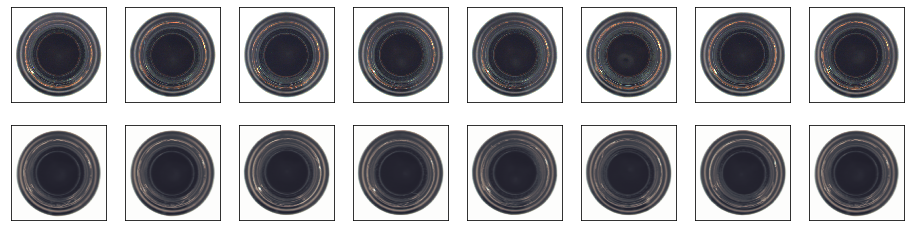

In [36]:
plot_samples(
    next(yield_images(X_normal_test, 8, single_batch=True, input_only=True)),
    decoded_normal_imgs,
    plot_mvtec,
    os.path.join(img_path, "rec-{}.png".format(NORMAL_STR)),
)

In [37]:
encoded_anomaly_imgs = encoder.predict_generator(
    yield_images(X_anomaly_test, 1, input_only=True), steps=len(X_anomaly_test)
)  # used later for One Class Classification
print(encoded_anomaly_imgs.shape)

# decode batch wise:
batch_size_decode = 8

epochs = np.arange(0, len(encoded_anomaly_imgs), batch_size_decode)
decoded_anomaly_imgs = np.zeros((0, 900, 900, 3))

for i in range(len(epochs)):
    # print(epochs[i], epochs[i + 1] if i+1<len(epochs) else None)
    decoded_anomaly_imgs = np.concatenate(
        (decoded_anomaly_imgs,
        decoder.predict(encoded_anomaly_imgs[epochs[i] : epochs[i + 1] if i+1<len(epochs) else None]))
    )
len(decoded_anomaly_imgs)

(63, 225, 225, 2)


63

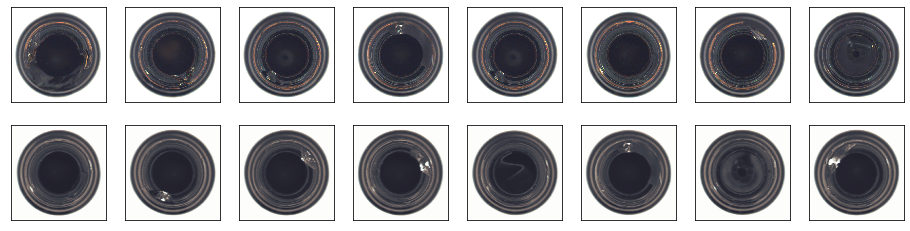

In [38]:
plot_samples(
    next(yield_images(X_anomaly_test, 8, single_batch=True, input_only=True)),
    decoded_anomaly_imgs,
    plot_mvtec,
    os.path.join(img_path, "rec-{}.png".format(ANOMALY_STR)),
)

# Anomaly detection
## Loss based
### Computing the reconstruction loss for anomalies and normalities

In [118]:
def loss_per_img(img,rec_img):
    return np.sum(np.power(rec_img - img,2))

In [ ]:
normal_losses = np.array(
    [
        loss_per_img(i, ri)
        for i, ri in zip(
            next(
                yield_images(
                    X_normal_test,
                    len(decoded_normal_imgs),
                    single_batch=True,
                    input_only=True,
                )
            ),
            decoded_normal_imgs,
        )
    ]
)
anomaly_losses = np.array(
    [
        loss_per_img(i, ri)
        for i, ri in zip(
            next(
                yield_images(
                    X_anomaly_test,
                    len(decoded_anomaly_imgs),
                    single_batch=True,
                    input_only=True,
                )
            ),
            decoded_anomaly_imgs,
        )
    ]
)
normal_losses.mean(), anomaly_losses.mean()

In [124]:
def plot_hist(values, bins=50, relative=False, color="r"):
    t = np.linspace(values.min(), values.max(), bins)
    denominator = len(values) if relative else 1
    hist = np.histogram(values, bins)
    plt.plot(t, hist[0]/denominator, color)

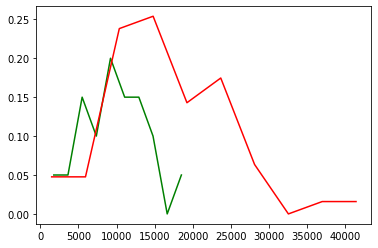

In [125]:
bins = 10
# loss distribution over the normal dataset
plot_hist(normal_losses,relative=True,color="g",bins=bins)
# loss distribution over the anomaly dataset 
plot_hist(anomaly_losses,relative=True,color="r",bins=bins)
plt.show()

### Evaluating the loss based approach

threshold:0.500,dn:0.500000 + ua:0.142857 = 0.321429
threshold:0.550,dn:0.450000 + ua:0.174603 = 0.312302
threshold:0.600,dn:0.400000 + ua:0.174603 = 0.287302
threshold:0.650,dn:0.350000 + ua:0.190476 = 0.270238
threshold:0.700,dn:0.300000 + ua:0.222222 = 0.261111
threshold:0.750,dn:0.250000 + ua:0.333333 = 0.291667
threshold:0.800,dn:0.250000 + ua:0.333333 = 0.291667
threshold:0.850,dn:0.150000 + ua:0.349206 = 0.249603
threshold:0.900,dn:0.100000 + ua:0.396825 = 0.248413
threshold:0.950,dn:0.050000 + ua:0.587302 = 0.318651


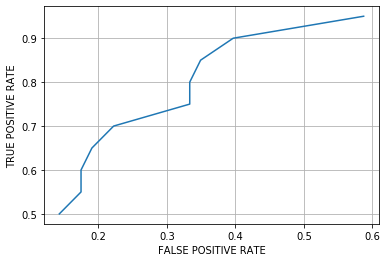

(0.9000000000000004, 14936.755058902914)

In [131]:
# x:= "false detected anomalies in %"
# y:= "correct detected normal data points in %"
FPs = FNs = []
prec = 20  # precision for getting the best threshold value
step_size = 1.0 / prec
TPs = np.arange(0.5, 1, step_size)

for i in TPs:
    # loss value for detection of i*100 percent normal data points
    loss_boundary = np.sort(normal_losses)[int(len(normal_losses) * i)]

    detected_normals = next(
        yield_images(
            X_normal_test,
            batch_size=len(X_normal_test),
            single_batch=True,
            input_only=True,
        )
    )[normal_losses >= loss_boundary]
    undetected_anomalies = next(
        yield_images(
            X_anomaly_test,
            batch_size=len(X_anomaly_test),
            single_batch=True,
            input_only=True,
        )
    )[anomaly_losses < loss_boundary]

    FP_rate = len(undetected_anomalies) / len(
        anomaly_losses
    )  # ratio between not detected loss values for anomalies
    FN_rate = len(detected_normals) / len(
        normal_losses
    )  # ratio between not detected loss values for anomalies

    FPs = np.append(FPs, FP_rate)  # not detected anomalies
    FNs = np.append(FNs, FN_rate)  # as anomalies detected normalities
    if (FP_rate + FN_rate)/2 <= min(
        (FNs + FPs)/2
    ):  # less or equal since we want the biggest TP_rate (i)
        loss_threshold = i
        best_boundary = loss_boundary

    # print every 1/10 threshold step
    if (int(i * prec)) % (prec // 20) == 0:
        print(
            "threshold:%.3f,dn:%f + ua:%f = %f"
            % (i, FN_rate, FP_rate, (FN_rate + FP_rate)/2)
        )
    # minimum value for FN_rate + FP_rate (least relative amount of falsely detected)

plt.plot(FPs, TPs)
plt.grid()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.show()
loss_threshold, best_boundary

In [132]:
detected_normals = next(
    yield_images(
        X_normal_test, batch_size=len(X_normal_test), single_batch=True, input_only=True
    )
)[
    normal_losses >= best_boundary
]  # values on the boundary are seen as anomalies
undetected_anomalies = next(
    yield_images(
        X_anomaly_test,
        batch_size=len(X_anomaly_test),
        single_batch=True,
        input_only=True,
    )
)[anomaly_losses < best_boundary]
len(detected_normals), len(undetected_anomalies)

(2, 25)

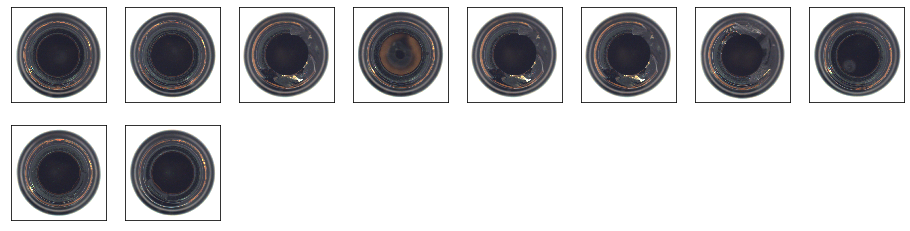

In [133]:
plot_samples(detected_normals,undetected_anomalies,plot_mvtec, os.path.join(img_path,"wrong-{}.png".format(USE_CASE)))

### Predicting with the reconstruction loss approach

In [139]:
def is_anomaly(X,boundary):
    rec_img = ae.predict(X.reshape(1,900,900,3))
    # plot_mvtec(rec_img.reshape(900,900,3))
    # plt.show()
    loss =  loss_per_img(rec_img,X)
    # print(loss)
    return loss > boundary

In [140]:
this_should_be_false = is_anomaly(next(yield_images(X_normal_test, batch_size=1,single_batch=True,input_only=True)), best_boundary)
this_should_be_true = is_anomaly(next(yield_images(X_anomaly_test,batch_size=1, single_batch=True,input_only=True)), best_boundary)
this_should_be_false, this_should_be_true

(False, False)

In [141]:
best_boundary, anomaly_losses

(14936.755058902914,
 array([16890.29507008, 10202.8782398 ,  9529.11228141, 21112.85677817,
        12310.37410947,  9535.33013472, 16915.74743459, 22772.79965403,
         9327.24705818, 22066.69551307,  1488.58371628, 25093.96587555,
         9369.02981422, 13161.88614597, 21575.23387303, 14217.92037951,
        21069.13147046, 22899.49100201, 15158.39631912, 15802.41138312,
        17204.75272016, 20752.120327  , 26437.7763563 , 23859.2701199 ,
         1874.66541804, 19268.91544504, 22462.93634125, 29289.90878388,
         2095.43533847, 21069.13147046, 11717.05794508, 19904.36205695,
        27856.02525435, 11599.54593356, 16072.84493524, 21378.02178926,
        19183.3573571 , 22170.51131196, 41422.51095612, 17010.60836868,
         9853.41073036, 12508.00431998, 13563.41011386, 15885.80034336,
        14819.96800333, 14386.97842015, 34255.59008654, 24412.21612333,
        24508.44487642, 13113.90546206, 13063.01339882,  8957.69161578,
        11059.75108519, 12054.43382857, 131

## One Class SVM approach

In [142]:
from sklearn import svm
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score,accuracy_score

In [143]:
encoded_normal_imgs_train = encoded_normal_imgs_train.reshape(
            -1, np.prod(encoded_normal_imgs_train.shape[1:])
        )
encoded_normal_imgs_test = encoded_normal_imgs_test.reshape(
            -1, np.prod(encoded_normal_imgs_test.shape[1:])
        )
encoded_anomaly_imgs = encoded_anomaly_imgs.reshape(-1, np.prod(encoded_anomaly_imgs.shape[1:]))
best_metrics =0
for i in np.arange(0.1, 1, 0.1):
    clf = svm.OneClassSVM(gamma="auto", nu=i)
    clf.fit(encoded_normal_imgs_train)
    
    score_normal = clf.predict(encoded_normal_imgs_test)
    bins = 2
    # hist_normal = np.histogram(score_normal, bins)
    # t = np.linspace(score_normal.min(), score_normal.max(), bins)
    # plt.bar(t, hist_normal[0], width=0.5, color="g")
    # plt.show()

    score_anomaly = clf.predict(encoded_anomaly_imgs)

    # hist_anomaly = np.histogram(score_anomaly, bins)
    # t = np.linspace(score_anomaly.min(), score_anomaly.max(), bins)
    # plt.bar(t, hist_anomaly[0], width=0.5, color="r")
    # plt.show()


    TP = len(score_normal[score_normal == 1])
    FN = len(score_normal[score_normal == -1])

    TN = len(score_anomaly[score_anomaly == -1])
    FP = len(score_anomaly[score_anomaly == 1])
    accuracy = (TP + TN) / (len(score_normal) + len(score_anomaly))
    precision = TP / (TP + FN)
    recall = TP / (TP + FP)
    if (accuracy+precision+recall)/3 > best_metrics:
        best_nu = i
        best_metrics = (accuracy+precision+recall)/3
        oc_svm = clf
    print("%.2f" % i, accuracy, precision, recall)
best_nu,best_metrics


0.10 0.6626506024096386 0.65 0.38235294117647056
0.20 0.7469879518072289 0.6 0.48
0.30 0.8192771084337349 0.55 0.6470588235294118
0.40 0.8192771084337349 0.55 0.6470588235294118
0.50 0.8554216867469879 0.4 1.0
0.60 0.8554216867469879 0.4 1.0
0.70 0.8192771084337349 0.25 1.0
0.80 0.8192771084337349 0.25 1.0
0.90 0.7710843373493976 0.05 1.0


(0.5, 0.7518072289156627)

In [144]:
def is_anomaly_svm(X,oc_svm):
    X = X.reshape((1,X.shape[0]))
    prediction = oc_svm.predict(X)[0]
    return prediction == -1

In [145]:
this_should_be_false_svm = is_anomaly_svm(encoded_normal_imgs_train[0], oc_svm)
this_should_be_true_svm = is_anomaly_svm(encoded_anomaly_imgs[0], oc_svm)
this_should_be_false_svm, this_should_be_true_svm

(True, True)

# TODO: Encoded feature analysis with our friend CF Gauss

In [146]:
flat_shape = np.prod(encoded_normal_imgs_train.shape[1:], dtype=np.int64)
encoded_normal_imgs_train = encoded_normal_imgs_train.reshape(
    len(encoded_normal_imgs_train), flat_shape
)
encoded_normal_imgs_test = encoded_normal_imgs_test.reshape(
    len(encoded_normal_imgs_test), flat_shape
)

In [147]:
def gauss(x_i, my_i, sigma_i2):
    # gaussian distribution for one feature
    if sigma_i2 == 0:
        return 1 if x_i == my_i else 0
    return np.array(
        (1 / np.sqrt(2 * np.pi * sigma_i2))
        * np.exp(-(x_i - my_i) ** 2 / (2 * sigma_i2))
    )

In [148]:
def my(X):
    return np.array([(1 / len(x)) * np.sum(x) for x in X.T])

In [149]:
def sigma2(X, my):
    # computes sigma squared for each feature
    m = len(X)  # number of data points
    return np.array([(1/m)*np.sum((X[:, i] - my[i]) ** 2) for i in range(len(my))])

In [150]:
def p(X,my,sigma2):
    return np.array([np.prod([gauss(x[i], my[i], sigma2[i])
               for i in range(len(x))]) for x in X])

In [156]:
X= encoded_normal_imgs_test
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = p(X, my, sigma_2)
my

array([1.99189777, 0.        , 2.20821114, ..., 0.53145118, 1.85000763,
       0.30248611])

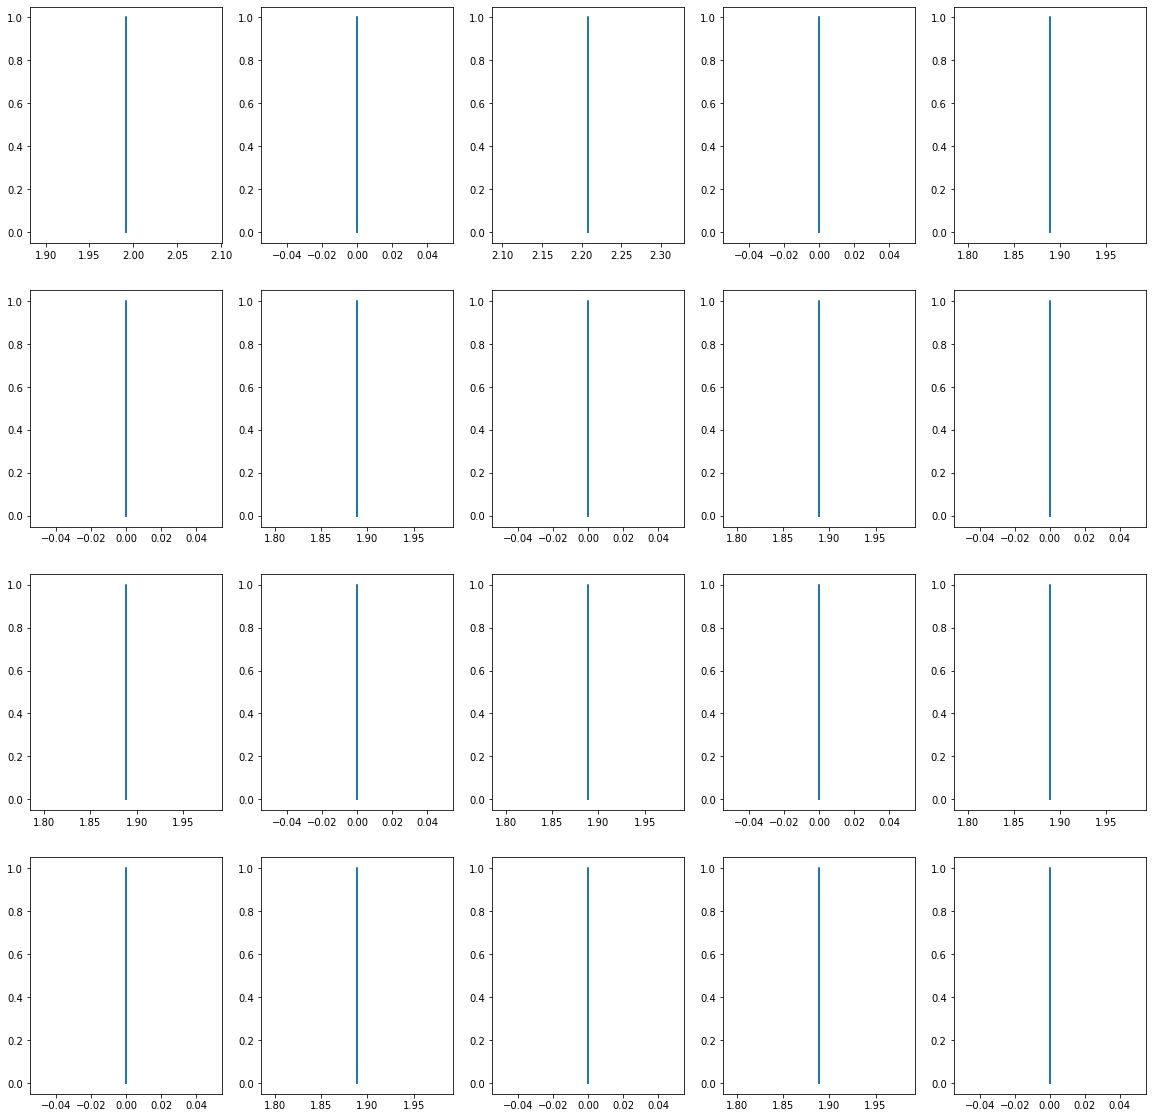

In [158]:
plt.figure(figsize=(20, 20))
for i in range(20):
    # plots distribution of i-th feature
    # display original
    bins = 20
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 5, i + 1)
    r = np.linspace(start=min(X[:, i]), stop=max(X[:, i]), num=bins)
    plt.plot(r, hist[0]/len(X[:,i]))

In [ ]:
X= encoded_anomaly_imgs
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = p(X, my, sigma_2)
plt.figure(figsize=(20, 20))
for i in range(len(my)-1):
    # plots distribution of i-th feature
    # display original
    bins = 20
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 6, i + 1)
    r = np.linspace(start=min(X[:, i]), stop=max(X[:, i]), num=bins)
    plt.plot(r, hist[0]/len(X[:,i]))